In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/My Drive/Kaggle_Data/P2P lending/

/content/gdrive/My Drive/Kaggle_Data/P2P lending


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
data =  pd.read_csv("data_2.csv",index_col=False)

In [ ]:
data.head(3)

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,...,addr_state:IL,addr_state:IN,addr_state:KS,addr_state:KY,addr_state:LA,addr_state:MA,addr_state:MD,addr_state:ME,addr_state:MI,addr_state:MN,addr_state:MO,addr_state:MS,addr_state:MT,addr_state:NC,addr_state:ND,addr_state:NE,addr_state:NH,addr_state:NJ,addr_state:NM,addr_state:NV,addr_state:NY,addr_state:OH,addr_state:OK,addr_state:OR,addr_state:PA,addr_state:RI,addr_state:SC,addr_state:SD,addr_state:TN,addr_state:TX,addr_state:UT,addr_state:VA,addr_state:VT,addr_state:WA,addr_state:WI,addr_state:WV,addr_state:WY,initial_list_status:f,initial_list_status:w,Non-Default_Default
0,84574055,8000.0,8000.0,8000.0,36 months,15.59,279.64,C,C5,Produce Clerk,10+ years,RENT,36000.0,Source Verified,Jul-2016,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,other,Other,107xx,NY,12.50,1.0,Mar-2000,670.0,674.0,0.0,22.0,NaN,4.0,0.0,1319.0,48.9,7.0,f,0.0,0.0,2556.26,2556.26,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,42297471,16000.0,16000.0,16000.0,60 months,12.69,361.52,C,C2,Supervisor,10+ years,RENT,55000.0,Source Verified,Apr-2015,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,331xx,FL,12.50,0.0,Jul-2006,695.0,699.0,0.0,NaN,NaN,5.0,0.0,11555.0,82.5,10.0,w,0.0,0.0,14741.28,14741.28,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,48140617,10000.0,10000.0,10000.0,60 months,14.65,236.07,C,C5,Sales Agent,5 years,MORTGAGE,50000.0,Source Verified,May-2015,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,credit_card,Credit card refinancing,466xx,IN,25.68,0.0,Mar-2006,660.0,664.0,1.0,NaN,41.0,10.0,1.0,8376.0,50.8,24.0,w,0.0,0.0,3002.63,3002.63,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


# **Preprocessing Continues variables**

**Fine Classing is:** Splitting a vaiable into roughly equal categories according to an internal criteria, such as the values of the variable or the number of cases in each category.

**Coarse classing is:** Splitting a variable into categories according to an external criteria that show how much the categories explain another variable, such as Weight of evidence.

**Weight of Evidence shows:** The extent to which a categorical independent variable explains the difference of a categorical outcome variable.

## **1. Splitting the data**

In [ ]:
from sklearn.model_selection import train_test_split as tts

In [ ]:
data_inputs_train,data_inputs_test,data_targets_train,data_targets_test=tts(data.drop('Non-Default_Default',axis=1),data['Non-Default_Default'],test_size=0.2, random_state=42)

In [ ]:
data_inputs_train.shape

(465323, 193)

In [ ]:
data_inputs_test.shape

(116331, 193)

## **Example** of Preprocessing an applying Weight of Evidence and Information value

In [ ]:
input_pr=data_inputs_train
target_pr=data_targets_train

In [ ]:
input_pr['grade'].unique()

array(['D', 'C', 'B', 'F', 'A', 'E', 'G'], dtype=object)

The example will be done on the 'grade' variable where the formula of Weight of Evidence will be applied
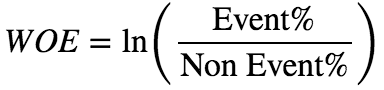

In [ ]:
g1=pd.concat([input_pr['grade'],target_pr],axis=1)
g1.head()

,grade,Non-Default_Default
285640,D,0
89702,C,0
368775,D,1
541137,B,1
502566,B,1


In [ ]:
g1=pd.concat([g1.groupby(g1.columns.values[0],as_index=False)[g1.columns.values[1]].count(),g1.groupby(g1.columns.values[0],as_index=False)[g1.columns.values[1]].mean()],axis=1)
g1=g1.iloc[:,[0,1,3]]
g1.columns=[g1.columns.values[0],'n_obs','prop_good']
g1['prop_n_obs']=g1['n_obs']/g1['n_obs'].sum()
g1['n_good']=g1['prop_good']*g1['n_obs']
g1['n_default']=(1-g1['prop_good'])*g1['n_obs']
g1['prop_n_good']=g1['n_good']/g1['n_good'].sum()
g1['prop_n_default']=g1['n_default']/g1['n_default'].sum()
g1['WoE']=np.log(g1['prop_n_good']/g1['prop_n_default'])
g1=g1.sort_values(['WoE'])
g1=g1.reset_index(drop=True)

g1

,grade,n_obs,prop_good,prop_n_obs,n_good,n_default,prop_n_good,prop_n_default,WoE
0,G,4740,0.181435,0.010186,860.0,3880.0,0.003698,0.016668,-1.505631
1,F,15318,0.207272,0.032919,3175.0,12143.0,0.013653,0.052165,-1.340418
2,E,42159,0.269053,0.090602,11343.0,30816.0,0.048778,0.132382,-0.998406
3,D,83308,0.365679,0.179033,30464.0,52844.0,0.131004,0.227012,-0.549771
4,C,140554,0.469101,0.302057,65934.0,74620.0,0.283536,0.320559,-0.122727
5,B,117526,0.608240,0.252569,71484.0,46042.0,0.307403,0.197791,0.440947
6,A,61718,0.798503,0.132635,49282.0,12436.0,0.211927,0.053424,1.377991


In [ ]:
g1['diff_prop_good']=g1['prop_good'].diff().abs()
g1['diif_WoE']=g1['WoE'].diff().abs()
g1

,grade,n_obs,prop_good,prop_n_obs,n_good,n_default,prop_n_good,prop_n_default,WoE,diff_prop_good,diif_WoE
0,G,4740,0.181435,0.010186,860.0,3880.0,0.003698,0.016668,-1.505631,NaN,NaN
1,F,15318,0.207272,0.032919,3175.0,12143.0,0.013653,0.052165,-1.340418,0.025838,0.165213
2,E,42159,0.269053,0.090602,11343.0,30816.0,0.048778,0.132382,-0.998406,0.061780,0.342012
3,D,83308,0.365679,0.179033,30464.0,52844.0,0.131004,0.227012,-0.549771,0.096626,0.448635
4,C,140554,0.469101,0.302057,65934.0,74620.0,0.283536,0.320559,-0.122727,0.103422,0.427044
5,B,117526,0.608240,0.252569,71484.0,46042.0,0.307403,0.197791,0.440947,0.139139,0.563674
6,A,61718,0.798503,0.132635,49282.0,12436.0,0.211927,0.053424,1.377991,0.190263,0.937044


In [ ]:
g1['IV']=(g1['prop_n_good']-g1['prop_n_default'])*g1['WoE']
g1['IV']=g1['IV'].sum()
g1

,grade,n_obs,prop_good,prop_n_obs,n_good,n_default,prop_n_good,prop_n_default,WoE,diff_prop_good,diif_WoE,IV
0,G,4740,0.181435,0.010186,860.0,3880.0,0.003698,0.016668,-1.505631,NaN,NaN,0.478695
1,F,15318,0.207272,0.032919,3175.0,12143.0,0.013653,0.052165,-1.340418,0.025838,0.165213,0.478695
2,E,42159,0.269053,0.090602,11343.0,30816.0,0.048778,0.132382,-0.998406,0.061780,0.342012,0.478695
3,D,83308,0.365679,0.179033,30464.0,52844.0,0.131004,0.227012,-0.549771,0.096626,0.448635,0.478695
4,C,140554,0.469101,0.302057,65934.0,74620.0,0.283536,0.320559,-0.122727,0.103422,0.427044,0.478695
5,B,117526,0.608240,0.252569,71484.0,46042.0,0.307403,0.197791,0.440947,0.139139,0.563674,0.478695
6,A,61718,0.798503,0.132635,49282.0,12436.0,0.211927,0.053424,1.377991,0.190263,0.937044,0.478695


## To Automate the Calculation of Woe and IV I would create function

In [ ]:
def woe_dis(df,discrete_variable_name,good_default_variable_df):
  df=pd.concat([df[discrete_variable_name],good_default_variable_df],axis=1)
  df=pd.concat([df.groupby(df.columns.values[0],as_index=False)[df.columns.values[1]].count(),df.groupby(df.columns.values[0],as_index=False)[df.columns.values[1]].mean()],axis=1)
  df=df.iloc[:,[0,1,3]]
  df.columns=[df.columns.values[0],'n_obs','prop_good']
  df['prop_n_obs']=df['n_obs']/df['n_obs'].sum()
  df['n_good']=df['prop_good']*df['n_obs']
  df['n_default']=(1-df['prop_good'])*df['n_obs']
  df['prop_n_good']=df['n_good']/df['n_good'].sum()
  df['prop_n_default']=df['n_default']/df['n_default'].sum()
  df['WoE']=np.log(df['prop_n_good']/df['prop_n_default'])
  df=df.sort_values(['WoE'])
  df=df.reset_index(drop=True)
  df['diff_prop_good']=df['prop_good'].diff().abs()
  df['diif_WoE']=df['WoE'].diff().abs()
  df['IV']=(df['prop_n_good']-df['prop_n_default'])*df['WoE']
  df['IV']=df['IV'].sum()
  return df

In [ ]:
g1_temp=woe_dis(input_pr,'grade',target_pr)

In [ ]:
g1_temp
# Since we got the same result for g1 and g1_temp the function is working fine

,grade,n_obs,prop_good,prop_n_obs,n_good,n_default,prop_n_good,prop_n_default,WoE,diff_prop_good,diif_WoE,IV
0,G,4740,0.181435,0.010186,860.0,3880.0,0.003698,0.016668,-1.505631,NaN,NaN,0.478695
1,F,15318,0.207272,0.032919,3175.0,12143.0,0.013653,0.052165,-1.340418,0.025838,0.165213,0.478695
2,E,42159,0.269053,0.090602,11343.0,30816.0,0.048778,0.132382,-0.998406,0.061780,0.342012,0.478695
3,D,83308,0.365679,0.179033,30464.0,52844.0,0.131004,0.227012,-0.549771,0.096626,0.448635,0.478695
4,C,140554,0.469101,0.302057,65934.0,74620.0,0.283536,0.320559,-0.122727,0.103422,0.427044,0.478695
5,B,117526,0.608240,0.252569,71484.0,46042.0,0.307403,0.197791,0.440947,0.139139,0.563674,0.478695
6,A,61718,0.798503,0.132635,49282.0,12436.0,0.211927,0.053424,1.377991,0.190263,0.937044,0.478695


**now to achieve one of the objective of the reasrch a visulization function will be created to ilustrate the weight of eveidence for each categorical value**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()




In [ ]:
def plot_by_woe(df_WoE, rotation_of_x_labels=0):
	x=np.array(df_WoE.iloc[:,0].apply(str))
	y=df_WoE['WoE']
	plt.figure(figsize = (18,6))
	plt.plot(x,y,marker='o',linestyle = '--',color='k')
	plt.xlabel(df_WoE.columns[0])
	plt.ylabel('Weight of Evidence')
	plt.title(str('Weight of Evidence by '+df_WoE.columns[0]))
	plt.xticks(rotation =rotation_of_x_labels)

## **Grade column**
**Lending Club assigned loan grade**


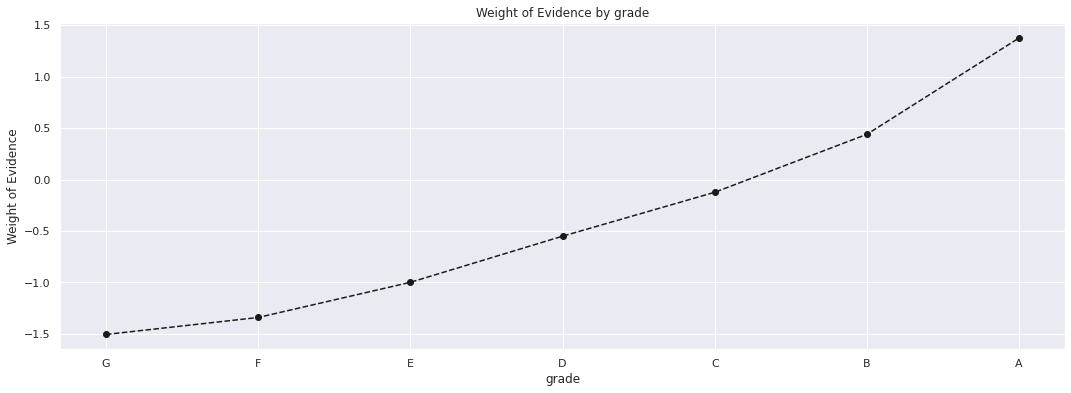

In [ ]:
plot_by_woe(g1_temp)

## **home_ownership**
The home ownership status provided by the borrower during registration. Our values are: RENT, OWN, MORTGAGE, OTHER.

applying the two funciton of homeownership variable

In [ ]:
data['home_ownership'].value_counts()

MORTGAGE    270524
RENT        245628
OWN          65223
ANY            208
OTHER           59
NONE            12
Name: home_ownership, dtype: int64

In [ ]:
g2=woe_dis(input_pr,'home_ownership',target_pr)
g2

,home_ownership,n_obs,prop_good,prop_n_obs,n_good,n_default,prop_n_good,prop_n_default,WoE,diff_prop_good,diif_WoE,IV
0,NONE,9,0.333333,0.000019,3.0,6.0,0.000013,0.000026,-0.692120,NaN,NaN,0.026448
1,OTHER,45,0.355556,0.000097,16.0,29.0,0.000069,0.000125,-0.593680,0.022222,0.098440,0.026448
2,RENT,196364,0.454559,0.421995,89259.0,107105.0,0.383840,0.460111,-0.181240,0.099003,0.412440,0.026448
3,OWN,52194,0.499943,0.112167,26094.0,26100.0,0.112212,0.112123,0.000797,0.045384,0.182037,0.026448
4,MORTGAGE,216543,0.540590,0.465361,117061.0,99482.0,0.503397,0.427363,0.163746,0.040648,0.162948,0.026448
5,ANY,168,0.648810,0.000361,109.0,59.0,0.000469,0.000253,0.614838,0.108219,0.451092,0.026448


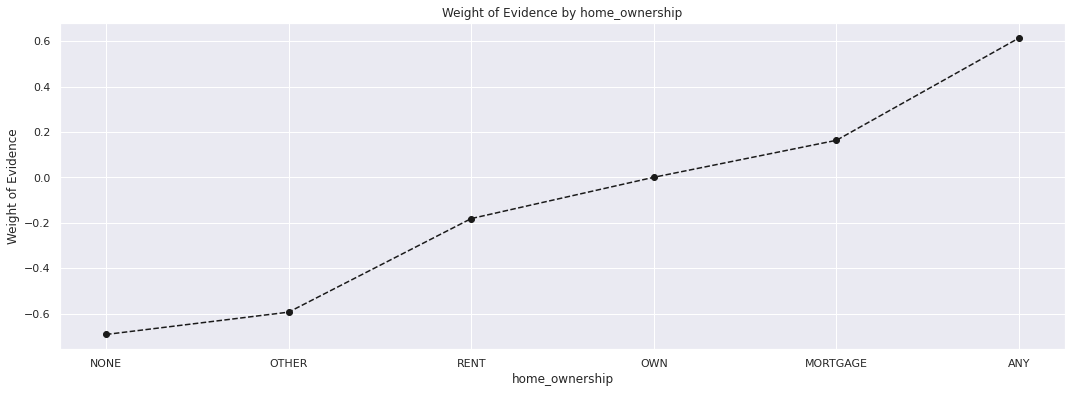

In [ ]:
plot_by_woe(g2)

In [ ]:
input_pr['home_ownership:RENT_OTHER_NONE']=sum([input_pr['home_ownership:RENT'],input_pr['home_ownership:OTHER'],input_pr['home_ownership:NONE']])
input_pr['home_ownership:MORTGAGE_ANY']=sum([input_pr['home_ownership:MORTGAGE'],input_pr['home_ownership:ANY']])


## **addr_state**

**The state provided by the borrower in the loan application**

In [ ]:
data['addr_state'].unique()

array(['NY', 'FL', 'IN', 'MI', 'GA', 'KS', 'CA', 'AZ', 'NH', 'KY', 'IL',
       'RI', 'TX', 'AR', 'CO', 'MA', 'NJ', 'WI', 'NV', 'CT', 'ND', 'AL',
       'MD', 'VA', 'ME', 'NC', 'WA', 'OR', 'OH', 'MO', 'LA', 'TN', 'OK',
       'PA', 'NM', 'SC', 'AK', 'UT', 'MS', 'MN', 'MT', 'DE', 'WV', 'NE',
       'HI', 'SD', 'ID', 'DC', 'WY', 'VT', 'IA'], dtype=object)

In [ ]:
#The count of each category
data['addr_state'].value_counts()

CA    81748
NY    49925
TX    47864
FL    43150
IL    22040
NJ    21584
PA    20096
OH    19264
GA    18394
NC    16441
VA    16237
MI    15379
MD    14301
AZ    13826
MA    12956
WA    11259
CO    11247
MN    10082
IN     9809
MO     9495
TN     9244
NV     8780
CT     8591
AL     7696
WI     7358
LA     7155
SC     6646
OR     6090
KY     5729
OK     5725
AR     4741
KS     4483
UT     3765
MS     3540
NM     3298
HI     2887
NH     2556
RI     2453
WV     1984
NE     1972
DE     1630
MT     1492
AK     1328
SD     1231
DC     1186
WY     1136
VT     1050
ME      995
ID      938
ND      871
IA        7
Name: addr_state, dtype: int64

In [ ]:
# the percantage of each category
data['addr_state'].value_counts() / len(data['addr_state'])

CA    0.140544
NY    0.085833
TX    0.082289
FL    0.074185
IL    0.037892
NJ    0.037108
PA    0.034550
OH    0.033119
GA    0.031624
NC    0.028266
VA    0.027915
MI    0.026440
MD    0.024587
AZ    0.023770
MA    0.022274
WA    0.019357
CO    0.019336
MN    0.017333
IN    0.016864
MO    0.016324
TN    0.015893
NV    0.015095
CT    0.014770
AL    0.013231
WI    0.012650
LA    0.012301
SC    0.011426
OR    0.010470
KY    0.009849
OK    0.009843
AR    0.008151
KS    0.007707
UT    0.006473
MS    0.006086
NM    0.005670
HI    0.004963
NH    0.004394
RI    0.004217
WV    0.003411
NE    0.003390
DE    0.002802
MT    0.002565
AK    0.002283
SD    0.002116
DC    0.002039
WY    0.001953
VT    0.001805
ME    0.001711
ID    0.001613
ND    0.001497
IA    0.000012
Name: addr_state, dtype: float64

In [ ]:
# normlizing the data to check for highest number of obesarvation for all addr_state categories.
(data['addr_state'].value_counts()-data['addr_state'].value_counts().min())/(data['addr_state'].value_counts().max()-data['addr_state'].value_counts().min())

CA    1.000000
NY    0.610685
TX    0.585471
FL    0.527801
IL    0.269546
NJ    0.263968
PA    0.245764
OH    0.235586
GA    0.224942
NC    0.201050
VA    0.198554
MI    0.188057
MD    0.174869
AZ    0.169058
MA    0.158415
WA    0.137654
CO    0.137507
MN    0.123255
IN    0.119915
MO    0.116074
TN    0.113003
NV    0.107327
CT    0.105015
AL    0.094065
WI    0.089930
LA    0.087447
SC    0.081220
OR    0.074418
KY    0.070002
OK    0.069953
AR    0.057915
KS    0.054758
UT    0.045974
MS    0.043222
NM    0.040261
HI    0.035233
NH    0.031184
RI    0.029924
WV    0.024186
NE    0.024039
DE    0.019855
MT    0.018167
AK    0.016161
SD    0.014974
DC    0.014424
WY    0.013812
VT    0.012760
ME    0.012087
ID    0.011390
ND    0.010570
IA    0.000000
Name: addr_state, dtype: float64

In [ ]:
g2=woe_dis(input_pr,'addr_state',target_pr)
g2

,addr_state,n_obs,prop_good,prop_n_obs,n_good,n_default,prop_n_good,prop_n_default,WoE,diff_prop_good,diif_WoE,IV
0,AR,3798,0.448920,0.008162,1705.0,2093.0,0.007332,0.008991,-0.204006,NaN,NaN,0.014294
1,AL,6100,0.454098,0.013109,2770.0,3330.0,0.011912,0.014305,-0.183098,0.005178,0.020908,0.014294
2,MS,2827,0.457022,0.006075,1292.0,1535.0,0.005556,0.006594,-0.171312,0.002923,0.011786,0.014294
3,NV,7009,0.458411,0.015063,3213.0,3796.0,0.013817,0.016307,-0.165716,0.001389,0.005596,0.014294
4,OK,4588,0.461857,0.009860,2119.0,2469.0,0.009112,0.010607,-0.151842,0.003446,0.013874,0.014294
5,LA,5747,0.466156,0.012351,2679.0,3068.0,0.011520,0.013180,-0.134555,0.004299,0.017287,0.014294
6,NY,40013,0.472346,0.085990,18900.0,21113.0,0.081276,0.090699,-0.109700,0.006190,0.024855,0.014294
7,FL,34652,0.478385,0.074469,16577.0,18075.0,0.071286,0.077648,-0.085486,0.006039,0.024213,0.014294
8,MO,7586,0.481413,0.016303,3652.0,3934.0,0.015705,0.016900,-0.073355,0.003028,0.012132,0.014294
9,NC,13094,0.482053,0.028140,6312.0,6782.0,0.027143,0.029135,-0.070792,0.000640,0.002562,0.014294


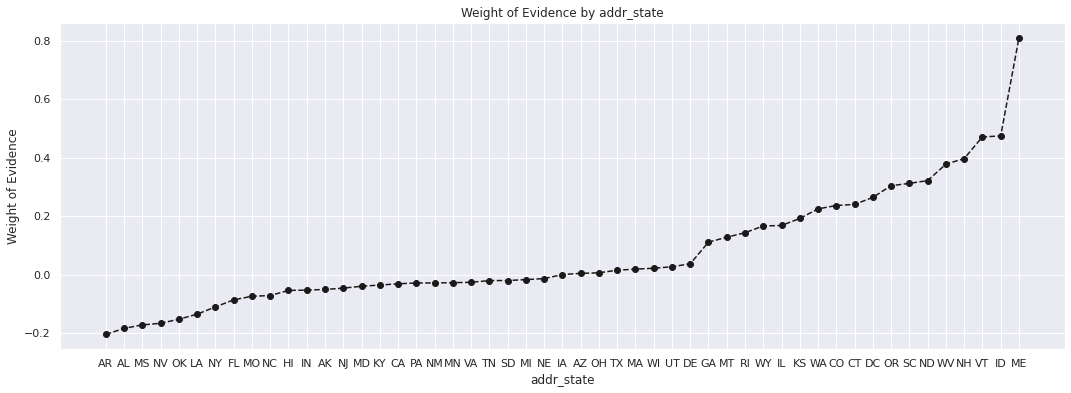

In [ ]:
plot_by_woe(g2)

In [ ]:
# checking for the missing states which didn't show up in the woe graph
if ['addr_state:IA'] in input_pr.columns.values:
	pass
else:
	input_pr['addr_state:IA']=0

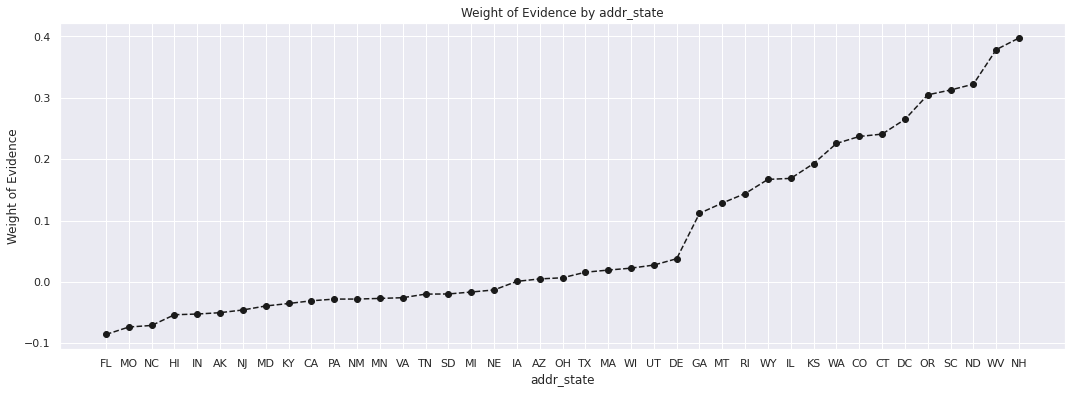

In [ ]:
plot_by_woe(g2.iloc[7:-3,:])

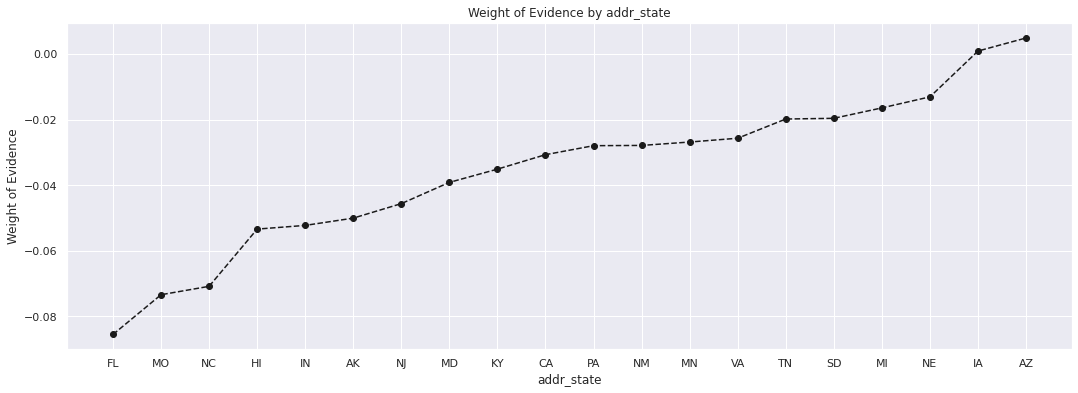

In [ ]:
plot_by_woe(g2.iloc[7:-24,:])

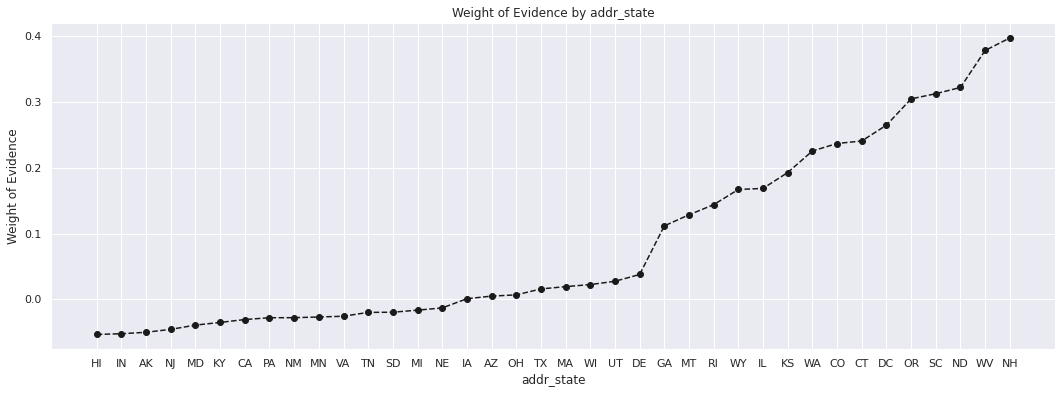

In [ ]:
plot_by_woe(g2.iloc[10:-3,:])

After review the 'addre_state' variable the number of dumie variable will be reduce and different states will be grouped to gether based on WoE value

In [ ]:
 
input_pr['addr_state:IA_OK_AR_AL_LA_HI_MS']=sum([input_pr['addr_state:IA'],input_pr['addr_state:OK'],input_pr['addr_state:AR'],input_pr['addr_state:AL'],input_pr['addr_state:LA'],input_pr['addr_state:HI']
                                                 ,input_pr['addr_state:MS']])
input_pr['addr_state:SD_NY_NM_NV']=sum([input_pr['addr_state:SD'],input_pr['addr_state:NY'],input_pr['addr_state:MN'],input_pr['addr_state:NV']])
input_pr['addr_state:FL_NC']=sum([input_pr['addr_state:FL'],input_pr['addr_state:NC']])
input_pr['addr_state:MD_KY_NJ_IN']=sum([input_pr['addr_state:MD'],input_pr['addr_state:KY'],input_pr['addr_state:NJ'],input_pr['addr_state:IN']])
input_pr['addr_state:VA_PA_MO_TN']=sum([input_pr['addr_state:VA'],input_pr['addr_state:PA'],input_pr['addr_state:MO'],input_pr['addr_state:TN']])
input_pr['addr_state:MN_CA']=sum([input_pr['addr_state:MN'],input_pr['addr_state:CA']])
input_pr['addr_state:NE_AZ_AK_MI']=sum([input_pr['addr_state:NE'],input_pr['addr_state:AZ'],input_pr['addr_state:AK'],input_pr['addr_state:MI']])
input_pr['addr_state:MA_UT_OH']=sum([input_pr['addr_state:MA'],input_pr['addr_state:UT'],input_pr['addr_state:OH']])
input_pr['addr_state:DE_GA_WI_WY']=sum([input_pr['addr_state:DE'],input_pr['addr_state:GA'],input_pr['addr_state:WI'],input_pr['addr_state:WY']])
input_pr['addr_state:MT_RI_IL']=sum([input_pr['addr_state:MT'],input_pr['addr_state:RI'],input_pr['addr_state:IL']])
input_pr['addr_state:KS_CO_CT_WA_ND_SC']=sum([input_pr['addr_state:KS'],input_pr['addr_state:CO'],input_pr['addr_state:CT'],input_pr['addr_state:WA'],input_pr['addr_state:ND'],input_pr['addr_state:SC']])
input_pr['addr_state:NH_WV_OR_DC']=sum([input_pr['addr_state:NH'],input_pr['addr_state:WV'],input_pr['addr_state:OR'],input_pr['addr_state:DC']])
input_pr['addr_state:ID_VT_ME']=sum([input_pr['addr_state:ID'],input_pr['addr_state:VT'],input_pr['addr_state:ME']])

## verification_status

**verification of the applicant's income.**

In [ ]:
data['verification_status'].unique()

array(['Source Verified', 'Verified', 'Not Verified'], dtype=object)

In [ ]:
data['verification_status'].value_counts()

Source Verified    231651
Verified           184068
Not Verified       165935
Name: verification_status, dtype: int64

In [ ]:
g2=woe_dis(input_pr,'verification_status',target_pr)
g2

,verification_status,n_obs,prop_good,prop_n_obs,n_good,n_default,prop_n_good,prop_n_default,WoE,diff_prop_good,diif_WoE,IV
0,Verified,147231,0.420401,0.316406,61896.0,85335.0,0.266171,0.366589,-0.320102,NaN,NaN,0.082291
1,Source Verified,185415,0.488828,0.398465,90636.0,94779.0,0.389762,0.407160,-0.043669,0.068427,0.276433,0.082291
2,Not Verified,132677,0.603043,0.285129,80010.0,52667.0,0.344067,0.226251,0.419190,0.114216,0.462859,0.082291


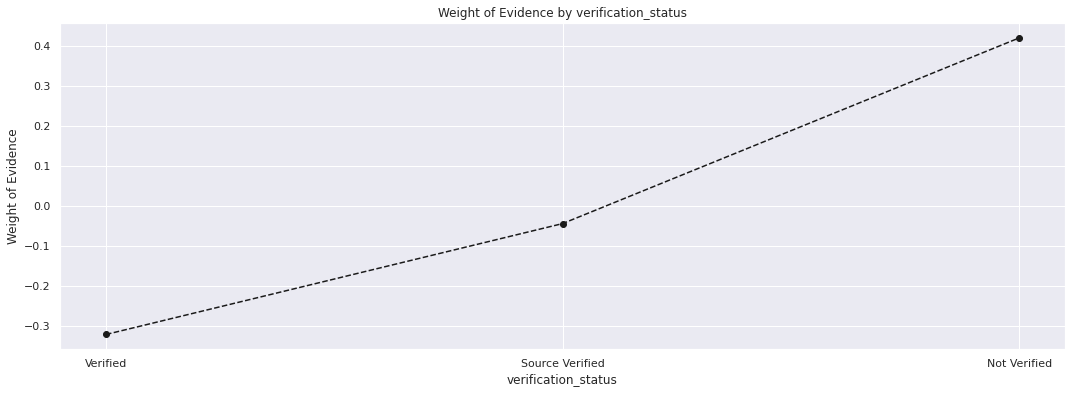

In [ ]:
plot_by_woe(g2)

## sub_grade
External Detailed grade associated with the loan

In [ ]:
data['sub_grade'].unique()

array(['C5', 'C2', 'B4', 'C1', 'E3', 'C3', 'D5', 'B3', 'F1', 'E1', 'B2',
       'D1', 'B5', 'D4', 'D2', 'F3', 'G4', 'B1', 'C4', 'E2', 'F2', 'D3',
       'A4', 'A5', 'E4', 'A2', 'E5', 'G3', 'G1', 'F5', 'A3', 'F4', 'G2',
       'G5', 'A1'], dtype=object)

In [ ]:
data['sub_grade'].value_counts()

C1    36611
C4    36124
C3    34808
C2    34582
B5    33684
C5    33605
B4    32368
B3    29073
B2    26483
B1    25381
D1    25290
D2    22761
A5    20899
D3    20732
D4    18950
A4    17306
D5    16407
A1    14224
A3    12758
E1    12632
A2    11901
E2    11643
E3    10430
E4     9080
E5     8830
F1     5756
F2     4290
F3     3620
F4     2991
F5     2520
G1     1901
G2     1321
G3     1043
G4      862
G5      788
Name: sub_grade, dtype: int64

In [ ]:
g2=woe_dis(input_pr,'sub_grade',target_pr)
g2

,sub_grade,n_obs,prop_good,prop_n_obs,n_good,n_default,prop_n_good,prop_n_default,WoE,diff_prop_good,diif_WoE,IV
0,G3,837,0.163680,0.001799,137.0,700.0,0.000589,0.003007,-1.630072,NaN,NaN,0.515515
1,G4,697,0.176471,0.001498,123.0,574.0,0.000529,0.002466,-1.539418,0.012791,0.090654,0.515515
2,F4,2392,0.177258,0.005141,424.0,1968.0,0.001823,0.008454,-1.534012,0.000787,0.005405,0.515515
3,G2,1061,0.178134,0.002280,189.0,872.0,0.000813,0.003746,-1.528015,0.000876,0.005997,0.515515
4,F5,2021,0.183572,0.004343,371.0,1650.0,0.001595,0.007088,-1.491301,0.005439,0.036714,0.515515
5,G5,624,0.185897,0.001341,116.0,508.0,0.000499,0.002182,-1.475864,0.002325,0.015437,0.515515
6,G1,1521,0.193951,0.003269,295.0,1226.0,0.001269,0.005267,-1.423510,0.008054,0.052354,0.515515
7,F3,2893,0.209125,0.006217,605.0,2288.0,0.002602,0.009829,-1.329178,0.015174,0.094332,0.515515
8,F2,3411,0.212254,0.007330,724.0,2687.0,0.003113,0.011543,-1.310362,0.003129,0.018816,0.515515
9,F1,4601,0.228429,0.009888,1051.0,3550.0,0.004520,0.015250,-1.216178,0.016174,0.094184,0.515515


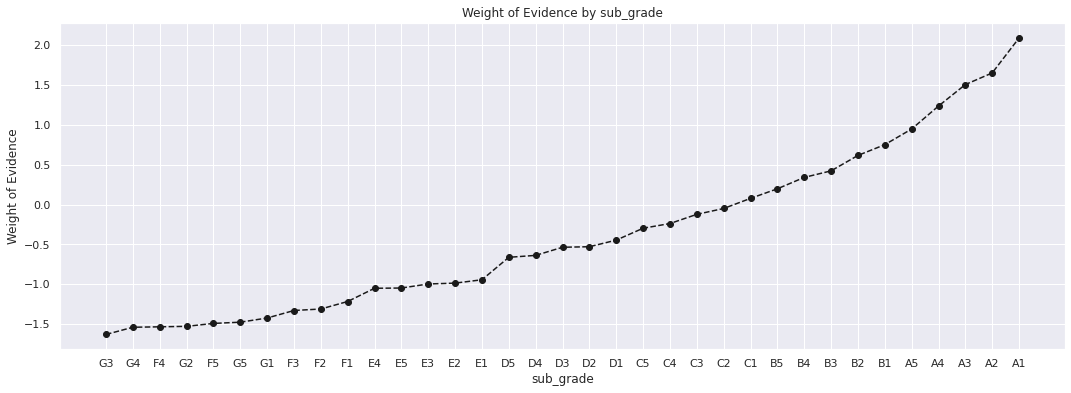

In [ ]:
plot_by_woe(g2)

In [ ]:
input_pr['sub_grade:G4_G3']=sum([input_pr['sub_grade:G4'],input_pr['sub_grade:G3']])
input_pr['sub_grade:F5_F4']=sum([input_pr['sub_grade:F5'],input_pr['sub_grade:F4']])
input_pr['sub_grade:G5_G2_F2_G1_F3']=sum([input_pr['sub_grade:F2'],input_pr['sub_grade:F3'],input_pr['sub_grade:G5'],input_pr['sub_grade:G2']])
input_pr['sub_grade:E3_E4_E5_E2_E1']=sum([input_pr['sub_grade:E3'],input_pr['sub_grade:E4'],input_pr['sub_grade:E5'],input_pr['sub_grade:E2'],input_pr['sub_grade:E1']])
input_pr['sub_grade:D4_D5']=sum([input_pr['sub_grade:D5'],input_pr['sub_grade:D4']])
input_pr['sub_grade:D3_D2_D1']=sum([input_pr['sub_grade:D3'],input_pr['sub_grade:D2'],input_pr['sub_grade:D1']])



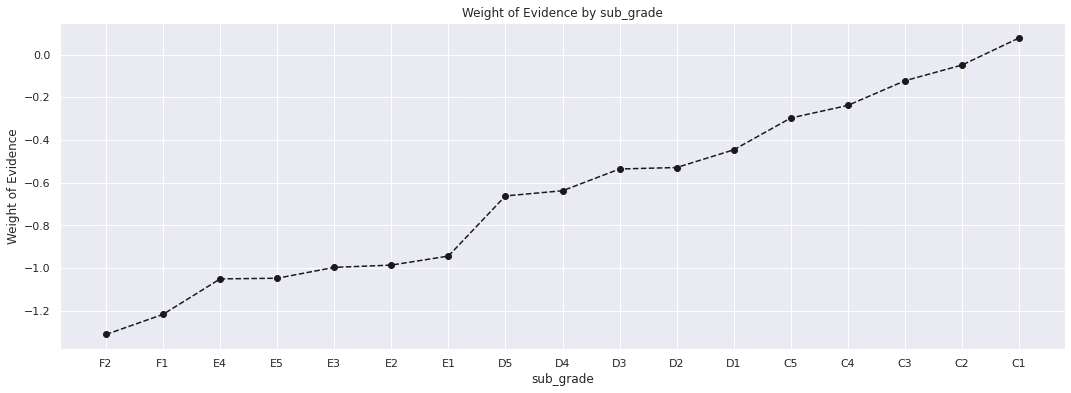

In [ ]:
plot_by_woe(g2.iloc[8:-10,:])

## **purpose**
**A category provided by the borrower for the loan request. **

In [ ]:
data['purpose'].unique()

array(['other', 'debt_consolidation', 'credit_card', 'medical',
       'home_improvement', 'small_business', 'moving', 'major_purchase',
       'house', 'car', 'vacation', 'wedding', 'renewable_energy',
       'educational'], dtype=object)

In [ ]:
data['purpose'].value_counts()

debt_consolidation    340330
credit_card           122483
home_improvement       36627
other                  35872
major_purchase         12646
small_business          7845
medical                 7253
car                     5611
moving                  4313
vacation                3954
house                   3552
wedding                  615
renewable_energy         405
educational              148
Name: purpose, dtype: int64

In [ ]:
g2=woe_dis(input_pr,'purpose',target_pr)
g2

,purpose,n_obs,prop_good,prop_n_obs,n_good,n_default,prop_n_good,prop_n_default,WoE,diff_prop_good,diif_WoE,IV
0,small_business,6292,0.360617,0.013522,2269.0,4023.0,0.009757,0.017282,-0.571661,NaN,NaN,0.023427
1,educational,114,0.385965,0.000245,44.0,70.0,0.000189,0.000301,-0.463278,0.025348,0.108383,0.023427
2,renewable_energy,331,0.401813,0.000711,133.0,198.0,0.000572,0.000851,-0.396891,0.015848,0.066388,0.023427
3,moving,3455,0.443705,0.007425,1533.0,1922.0,0.006592,0.008257,-0.225112,0.041892,0.171778,0.023427
4,debt_consolidation,272283,0.477566,0.585148,130033.0,142250.0,0.559181,0.611089,-0.088771,0.033861,0.136342,0.023427
5,house,2857,0.493175,0.006140,1409.0,1448.0,0.006059,0.006220,-0.026276,0.015609,0.062495,0.023427
6,other,28665,0.493808,0.061602,14155.0,14510.0,0.060871,0.062333,-0.023743,0.000633,0.002533,0.023427
7,medical,5830,0.493997,0.012529,2880.0,2950.0,0.012385,0.012673,-0.022988,0.000189,0.000755,0.023427
8,vacation,3153,0.516334,0.006776,1628.0,1525.0,0.007001,0.006551,0.066385,0.022337,0.089373,0.023427
9,major_purchase,10037,0.520873,0.021570,5228.0,4809.0,0.022482,0.020659,0.084567,0.004539,0.018182,0.023427


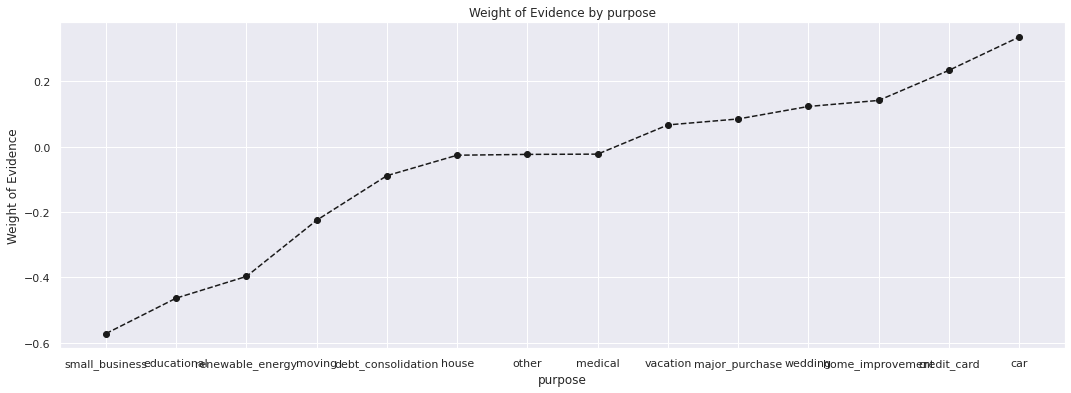

In [ ]:
plot_by_woe(g2)

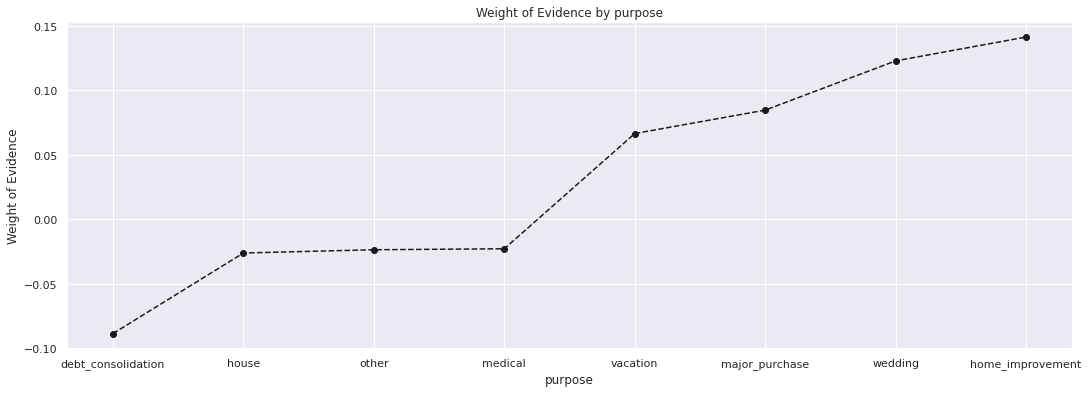

In [ ]:
plot_by_woe(g2.iloc[4:-2,:])

In [ ]:
input_pr['purpose:SB_RE_M']=sum([input_pr['purpose:small_business'],input_pr['purpose:renewable_energy'],input_pr['purpose:moving']])
input_pr['purpose:med_oth_wed_hou']=sum([input_pr['purpose:medical'],input_pr['purpose:other'],input_pr['purpose:wedding'],input_pr['purpose:house']])

## **initial_list_status**
**The initial listing status of the loan. Possible values are – W, F**

In [ ]:
g2=woe_dis(input_pr,'initial_list_status',target_pr)
g2

,initial_list_status,n_obs,prop_good,prop_n_obs,n_good,n_default,prop_n_good,prop_n_default,WoE,diff_prop_good,diif_WoE,IV
0,f,163928,0.436301,0.352289,71522.0,92406.0,0.307566,0.396965,-0.255160,NaN,NaN,0.03517
1,w,301395,0.534249,0.647711,161020.0,140375.0,0.692434,0.603035,0.138238,0.097948,0.393398,0.03517


## performin the changes on the data frame

In [ ]:
data['home_ownership:RENT_OTHER_NONE']=sum([data['home_ownership:RENT'],data['home_ownership:OTHER'],data['home_ownership:NONE']])
data['home_ownership:MORTGAGE_ANY']=sum([data['home_ownership:MORTGAGE'],data['home_ownership:ANY']])

In [ ]:
data['addr_state:IA_OK_AR_AL_LA_HI_MS']=sum([data['addr_state:IA'],data['addr_state:OK'],data['addr_state:AR'],data['addr_state:AL'],data['addr_state:LA'],data['addr_state:HI']
                                                 ,data['addr_state:MS']])
data['addr_state:SD_NY_NM_NV']=sum([data['addr_state:SD'],data['addr_state:NY'],data['addr_state:MN'],data['addr_state:NV']])
data['addr_state:FL_NC']=sum([data['addr_state:FL'],data['addr_state:NC']])
data['addr_state:MD_KY_NJ_IN']=sum([data['addr_state:MD'],data['addr_state:KY'],data['addr_state:NJ'],data['addr_state:IN']])
data['addr_state:VA_PA_MO_TN']=sum([data['addr_state:VA'],data['addr_state:PA'],data['addr_state:MO'],data['addr_state:TN']])
data['addr_state:MN_CA']=sum([data['addr_state:MN'],data['addr_state:CA']])
data['addr_state:NE_AZ_AK_MI']=sum([data['addr_state:NE'],data['addr_state:AZ'],data['addr_state:AK'],data['addr_state:MI']])
data['addr_state:MA_UT_OH']=sum([data['addr_state:MA'],data['addr_state:UT'],data['addr_state:OH']])
data['addr_state:DE_GA_WI_WY']=sum([data['addr_state:DE'],data['addr_state:GA'],data['addr_state:WI'],data['addr_state:WY']])
data['addr_state:MT_RI_IL']=sum([data['addr_state:MT'],data['addr_state:RI'],data['addr_state:IL']])
data['addr_state:KS_CO_CT_WA_ND_SC']=sum([data['addr_state:KS'],data['addr_state:CO'],data['addr_state:CT'],data['addr_state:WA'],data['addr_state:ND'],data['addr_state:SC']])
data['addr_state:NH_WV_OR_DC']=sum([data['addr_state:NH'],data['addr_state:WV'],data['addr_state:OR'],data['addr_state:DC']])
data['addr_state:ID_VT_ME']=sum([data['addr_state:ID'],data['addr_state:VT'],data['addr_state:ME']])

In [ ]:
data['sub_grade:G4_G3']=sum([data['sub_grade:G4'],data['sub_grade:G3']])
data['sub_grade:F5_F4']=sum([data['sub_grade:F5'],data['sub_grade:F4']])
data['sub_grade:G5_G2_F2_G1_F3']=sum([data['sub_grade:F2'],data['sub_grade:F3'],data['sub_grade:G5'],data['sub_grade:G2']])
data['sub_grade:E3_E4_E5_E2_E1']=sum([data['sub_grade:E3'],data['sub_grade:E4'],data['sub_grade:E5'],data['sub_grade:E2'],data['sub_grade:E1']])
data['sub_grade:D4_D5']=sum([data['sub_grade:D5'],data['sub_grade:D4']])
data['sub_grade:D3_D2_D1']=sum([data['sub_grade:D3'],data['sub_grade:D2'],data['sub_grade:D1']])

In [ ]:
data['purpose:SB_RE_M']=sum([data['purpose:small_business'],data['purpose:renewable_energy'],data['purpose:moving']])
data['purpose:med_oth_wed_hou']=sum([data['purpose:medical'],data['purpose:other'],data['purpose:wedding'],data['purpose:house']])

In [ ]:
data.to_csv('data_3.csv',index=False)